In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import StandardScaler

import week4 as w4
sc.setLogLevel('DEBUG')

## Lectura del fichero CSV

Vamos a cargar el fichero, que previamente hemos ingestado en HDFS, en un RDD de Spark, con el formato conveniente para nuestros objetivos.

In [2]:
lines = sc.textFile('/user/cloudera/T_F_DR14_ZooSpec_10000.csv')

In [3]:
# Vemos que hay 10.001 filas en el RDD. Esto quiere decir que incluye el header o cabecera
lines.count()

10001

In [4]:
# Vamos a desechar el header
lines_f = lines.zipWithIndex().filter(lambda tup: tup[1] > 0).map(lambda x: x[0])

In [5]:
# Convertimos las lineas de texto separado por comas en un DataFrame
rows = lines_f.map(lambda l: l.split(","))

def build_features_bis(p):
    return (p[0], int(p[1]), Vectors.dense([float(e) for e in p[2:]]),)

data = rows.map(build_features_bis)
df = sqlContext.createDataFrame(data, ['dr7objid', 'target', 'features'])

Tenemos un dataframe de 10000 filas y 3 columnas
* dr7objid: texto, id de la galaxia
* target: número entero, tipo de galaxia
* features: vector de 4096 posiciones con los píxeles

In [6]:
df.show(1)

+------------------+------+--------------------+
|          dr7objid|target|            features|
+------------------+------+--------------------+
|587725550669398023|     0|[0.0460588235294,...|
+------------------+------+--------------------+
only showing top 1 row



In [7]:
# Vemos el número de filas y de columnas que tiene el DataFrame
print('Número de filas (imágenes): {}'.format(df.count()))
print('Número de columnas (id + target + features): {}'.format(len(df.columns)))

Número de filas (imágenes): 10000
Número de columnas (id + target + features): 3


## Filtrado de imágenes no clasificadas

Para el entrenamiento no nos hacen falta todos los datos, nos basta con los datos de aquellas imágenes que se han clasificado satisfactoriamente. Así pues, vamos a descartar aquellas imágenes cuyo campo `target` tiene valor `0`.

In [8]:
# Vemos cuántas imágenes hay de cada tipo
# 0 = incierto
# 1 = elíptica
# 2 = espiral
df.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     0| 6299|
|     1| 1291|
|     2| 2410|
+------+-----+



In [9]:
# Construímos un nuevo DataFrame solamente con las imágenes clasificadas
labeled_df = df.filter(df['target'] != 0)

In [10]:
# Vemos que el número de imágenes seleccionadas es coherente con la query anterior
labeled_df.count()

3701

Vemos que valores toman los datos de este DataFrame

In [11]:
w4.describe_n(labeled_df, 4, 'features', 'feat_{0}')

,feat_0,feat_1,feat_2,feat_3
count,3701.000000,3701.000000,3701.000000,3701.000000
mean,0.027172,0.027012,0.027621,0.028306
std,0.041563,0.041741,0.043972,0.045705
min,0.000000,0.000000,0.000000,0.000000
25%,0.007843,0.008122,0.007843,0.007843
50%,0.016243,0.015965,0.016008,0.016580
75%,0.030349,0.027773,0.030314,0.031435
max,0.721420,0.623145,0.752718,0.827824


## Reducción de los datos: Principal Component Analysis (PCA)

Los datos de los atributos, no es el ideal para entrenar un algoritmo de clasificación:
* **es muy grande** 3701 filas * 4096 columnas ~ 15M de celdas
* **es poco denso** hay pocas muestras (3701 imágenes) para el número de atributos (4096 píxeles). De intentar aplicar algunos algoritmos de clasificación sobre este conjunto de datos, podríamos incurrir en la maldición del inglés.

Para solucionar ambos problemas utilizaremos el método PCA para reducir el número de atributos.

### Estandarización de los datos

Para poder aplicar la PCA, previamente tenemos que estandarizar los datos, eso es que todos los atributos esten centrados en 0 (tengan media 0).

In [15]:
# Construimos el modelo
scaler = StandardScaler(inputCol="features", outputCol="std_features",
                        withStd=False, withMean=True)
scalerModel = scaler.fit(labeled_df)

# Utilizamos el modelo para estandarizar los datos etiquetados
std_features = scalerModel.transform(labeled_df)

In [16]:
w4.describe_n(std_features, 4, 'std_features', 'std_feat_{0}')

,std_feat_0,std_feat_1,std_feat_2,std_feat_3
count,3.701000e+03,3.701000e+03,3.701000e+03,3.701000e+03
mean,6.690598e-12,1.943434e-11,-4.431901e-11,5.706545e-11
std,4.156322e-02,4.174148e-02,4.397182e-02,4.570456e-02
min,-2.717154e-02,-2.701181e-02,-2.762090e-02,-2.830577e-02
25%,-1.932841e-02,-1.889024e-02,-1.977776e-02,-2.046263e-02
50%,-1.092841e-02,-1.104710e-02,-1.161305e-02,-1.172537e-02
75%,3.177474e-03,7.607387e-04,2.692829e-03,3.129527e-03
max,6.942481e-01,5.961333e-01,7.250968e-01,7.995178e-01


### Aplicación de la PCA

Aplicamos la PCA.

En este caso utilizaremos una implementación propia de la PCA, puesto que a la implementación que se puede encontrar en spark 1.6 le faltan algunas características que nos serán de utilidad

In [17]:
import PCA as _pca

El cálculo de la PCA puede tardar un rato: entre 10 y 15 minutos.

In [18]:
# inicializamos un objeto PCA
p = _pca.PCA()

# Ajustamos el modelo a los datos etiquetados
p.fit(std_features, 'std_features')

### Número de componentes a conservar

Vamos a ver qué porcentaje de información conservamos. Debemos seleccionar un número (k) lo más pequeño posible de 
componentes intentando conservar la mayor cantidad de información.

La cantidad de información conservada la vemos con la función `explained_variance(k)` de la clase PCA.

In [21]:
100*p.explained_variance(200) # la cantidad de información conservada tomando 200 componentes es de 98.158%

98.158485581389328

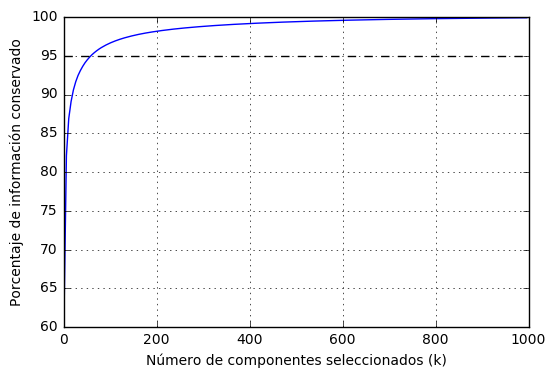

In [23]:
n_atr = range(1, 1000, 5)
info_perc = [100*p.explained_variance(i) for i in n_atr]
plt.plot(n_atr, info_perc)
plt.xlabel('Número de componentes seleccionados (k)')
plt.ylabel('Porcentaje de información conservado')
plt.axhline(95, color='k', linestyle='--')
plt.grid()

Tomaremos 64 componentes (`k=64`)

### Calculamos el porcentaje de la información que conservaremos con 64 componentes


In [22]:
100*p.explained_variance(64)

95.299254608923306

In [24]:
# Aplicamos el modelo ajustado a los datos etiquetados
pca_features = p.transform(std_features, 64, input_col='std_features', output_col='pca_features')

### Análisis de los componentes conservados

Los componentes conservados suelen capturar patrones significativos de los datos. Vemos en nuestro caso què son estos patrones.

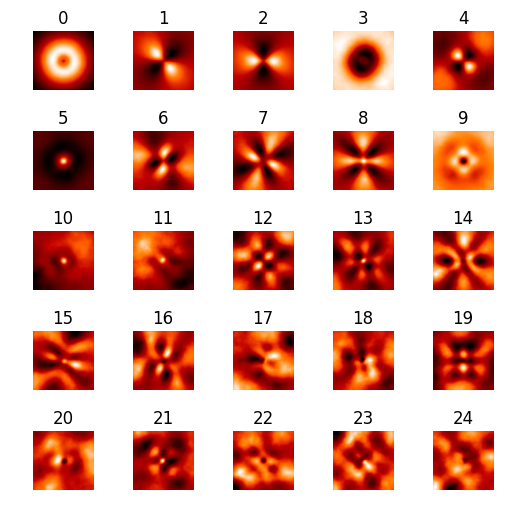

In [25]:
comp = p.eigVecs[0:64].T

n_comp_x = 5
n_comp_y = 5
g_size=1.
fig = plt.figure(figsize=(g_size*n_comp_x, g_size*n_comp_y))
for i in range(n_comp_x):
    for j in range(n_comp_y):
        comp_id = i*n_comp_y + j
        ax = fig.add_subplot(n_comp_y, n_comp_x, comp_id + 1)
        ax.imshow(comp[:, comp_id].reshape(64, 64), cmap='gist_heat')
        ax.set_title(comp_id)
        ax.axis('off')
plt.tight_layout(pad=0.)

Vemos que los componentes con mayor peso (aquellos con índices pequeños: 0, 1, 2, 3, ...) realmente contienen patrones semejantes a galaxias. A medida que seleccionamos componentes menos significativos, cada vez se asemejan menos a  patrones de galaxias.

Vamos a ver qué valores toman los primeros atributos de los datos reducidos mediante PCA

In [26]:
w4.describe_n(pca_features, 4, 'pca_features', 'pca_features_{0}')

,pca_features_0,pca_features_1,pca_features_2,pca_features_3
count,3.701000e+03,3.701000e+03,3.701000e+03,3.701000e+03
mean,-3.012298e-10,4.185268e-10,-8.409277e-10,-8.647154e-11
std,3.909868e+00,1.268498e+00,1.191271e+00,1.072211e+00
min,-6.334725e+00,-5.858991e+00,-5.077780e+00,-3.352803e+00
25%,-2.577986e+00,-6.038864e-01,-5.771616e-01,-6.847659e-01
50%,-1.303349e+00,-2.569970e-02,9.725398e-03,4.537893e-02
75%,1.095457e+00,5.763992e-01,5.658398e-01,6.507668e-01
max,2.747907e+01,5.319372e+00,6.620842e+00,9.549321e+00


## Grabamos los datos en formato parquet

In [27]:
pca_features.select('dr7objid', 'target', 'pca_features').\
    write.save('pca_features.parquet', format='parquet', mode='overwrite')

### Comprobamos que se ha guardado correctamente

Abrimos un terminal y hacemos
```
$ hdfs dfs -ls -h
```
Veremos que el fichero parquet ya está en disco
```
drwxr-xr-x   - cloudera cloudera          0 2018-05-09 00:41 PCA_components.pkl
-rw-r--r--   1 cloudera cloudera    605.0 M 2018-03-28 04:12 T_F_DR14_ZooSpec_10000.csv
drwxr-xr-x   - cloudera cloudera          0 2018-05-07 06:33 label_mean.pkl
drwxr-xr-x   - cloudera cloudera          0 2018-05-04 02:21 pca_features.parquet
```

De hecho no es un fichero, sino un directorio con varios ficheros en su interior. También podemos ver el contenido de este directorio:
```
$ hdfs dfs -ls -h pca_features.parquet

-rw-r--r--   1 cloudera cloudera          0 2018-05-04 02:21 pca_features.parquet/_SUCCESS
-rw-r--r--   1 cloudera cloudera        982 2018-05-04 02:21 pca_features.parquet/_common_metadata
-rw-r--r--   1 cloudera cloudera      4.6 K 2018-05-04 02:21 pca_features.parquet/_metadata
-rw-r--r--   1 cloudera cloudera    378.5 K 2018-05-04 02:20 pca_features.parquet/part-r-00000-43a02924-fb62-4858-8f29-876abd66795b.gz.parquet
-rw-r--r--   1 cloudera cloudera    374.5 K 2018-05-04 02:21 pca_features.parquet/part-r-00001-43a02924-fb62-4858-8f29-876abd66795b.gz.parquet
-rw-r--r--   1 cloudera cloudera    386.3 K 2018-05-04 02:21 pca_features.parquet/part-r-00002-43a02924-fb62-4858-8f29-876abd66795b.gz.parquet
-rw-r--r--   1 cloudera cloudera    398.5 K 2018-05-04 02:21 pca_features.parquet/part-r-00003-43a02924-fb62-4858-8f29-876abd66795b.gz.parquet
-rw-r--r--   1 cloudera cloudera    274.8 K 2018-05-04 02:21 pca_features.parquet/part-r-00004-43a02924-fb62-4858-8f29-876abd66795b.gz.parquet
```
